# Error Analysis Copol prediction (XGBoost)

In [3]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import rdMolDraw2D
import io
from PIL import Image
import matplotlib.offsetbox as offsetbox




# Set the plotting style
plt.style.use('lamalab.mplstyle')
# Set a consistent color scheme for train/test
colors = [
    '#340068',
    '#FF6978',
    '#FFFCF9',
    '#B1EDE8',
    '#6D435A'
]

# Load the error analysis data
df = pd.read_csv("../output/xgboost_predictions_for_error_analysis.csv")

# Filter out rows with NaN values in critical columns
nan_count_before = df.isna().sum().sum()
df = df.dropna(subset=['true_r1r2', 'pred_r1r2'])
nan_count_after = df.isna().sum().sum()
print(f"Loaded dataset with {len(df)} rows and {len(df.columns)} columns")
print(f"Removed {nan_count_before - nan_count_after} NaN values")

# Split into train and test sets
train_df = df[df['data_type'] == 'train'].copy()
test_df = df[df['data_type'] == 'test'].copy()
print(f"Train set: {len(train_df)} samples")
print(f"Test set: {len(test_df)} samples")

# Display the first few rows of each
print("\nFirst few rows of test data:")
display(test_df.head())


Loaded dataset with 14839 rows and 70 columns
Removed 44 NaN values
Train set: 11871 samples
Test set: 2968 samples

First few rows of test data:


,data_type,temperature,ip_corrected_1,ea_1,homo_1,lumo_1,global_electrophilicity_1,global_nucleophilicity_1,best_conformer_energy_1,charges_min_1,...,solvent_smiles,reaction_id,source_filename,true_r1r2,true_r12,true_r21,pred_r1r2,error_r1r2,abs_error_r1r2,rel_error_r1r2
0,test,60.0,7.888780,5.273380,-0.383166,-0.274799,1.158605,-7.888780,-44.209362,-0.404646,...,c1ccccc1,15.0,10.1002_macp.1984.021850311.json,0.088200,0.9800,0.0900,0.072357,0.015843,0.015843,17.962164
1,test,60.0,7.953530,5.027875,-0.386139,-0.267733,1.064522,-7.953530,-43.054268,-0.415387,...,C1COCCO1,27.0,10.1590_1516-1439.012015.json,0.139762,0.1490,0.9380,0.155386,-0.015624,0.015624,11.178834
2,test,70.0,9.390479,3.965117,-0.411266,-0.269488,0.881252,-9.390479,-22.894683,-0.411006,...,[Na+],33.0,10.1002_mren.201900014.json,0.661569,1.7919,0.3692,0.720680,-0.059111,0.059111,8.934892
3,test,50.0,8.243510,4.467538,-0.387676,-0.262906,0.896822,-8.243510,-25.211624,-0.181884,...,C1COCCO1,34.0,10.1021_ja01251a006.json,0.292000,1.4600,0.2000,0.347485,-0.055485,0.055485,19.001571
4,test,50.0,8.437776,4.455870,-0.393898,-0.264056,0.917044,-8.437776,-25.211530,-0.186144,...,C1COCCO1,36.0,10.1021_ja01251a006.json,0.284000,1.4200,0.2000,0.561841,-0.277841,0.277841,97.831489


In [4]:
print("\n### Basic Statistics ###")

# Function to calculate statistics for both train and test
def calculate_stats(train_data, test_data, column):
    train_stats = train_data[column].describe()
    test_stats = test_data[column].describe()
    return pd.DataFrame({
        f'Train {column}': train_stats,
        f'Test {column}': test_stats
    })

# Calculate statistics for true values, predictions, and errors
true_stats = calculate_stats(train_df, test_df, 'true_r1r2')
pred_stats = calculate_stats(train_df, test_df, 'pred_r1r2')
error_stats = calculate_stats(train_df, test_df, 'abs_error_r1r2')
rel_error_stats = calculate_stats(train_df, test_df, 'rel_error_r1r2')

# Display statistics
display(true_stats)
display(pred_stats)
display(error_stats)
display(rel_error_stats)

# Calculate metrics for train and test
train_r2 = r2_score(train_df['true_r1r2'], train_df['pred_r1r2'])
train_rmse = np.sqrt(mean_squared_error(train_df['true_r1r2'], train_df['pred_r1r2']))
train_mae = mean_absolute_error(train_df['true_r1r2'], train_df['pred_r1r2'])

test_r2 = r2_score(test_df['true_r1r2'], test_df['pred_r1r2'])
test_rmse = np.sqrt(mean_squared_error(test_df['true_r1r2'], test_df['pred_r1r2']))
test_mae = mean_absolute_error(test_df['true_r1r2'], test_df['pred_r1r2'])

metrics_df = pd.DataFrame({
    'Metric': ['R² Score', 'RMSE', 'MAE'],
    'Train': [train_r2, train_rmse, train_mae],
    'Test': [test_r2, test_rmse, test_mae]
})
display(metrics_df)


### Basic Statistics ###


,Train true_r1r2,Test true_r1r2
count,11871.000000,2968.000000
mean,1.208903,1.177435
std,10.288867,9.868097
min,0.000000,0.000000
25%,0.097550,0.098175
50%,0.335000,0.335500
75%,0.836400,0.836708
max,311.616000,311.616000


,Train pred_r1r2,Test pred_r1r2
count,11871.000000,2968.000000
mean,0.633906,0.538967
std,2.323031,1.026765
min,-0.032282,-0.059663
25%,0.126886,0.167177
50%,0.351547,0.355658
75%,0.738862,0.650398
max,78.766050,22.902678


,Train abs_error_r1r2,Test abs_error_r1r2
count,11871.000000,2968.000000
mean,0.634313,0.846323
std,9.124005,9.627886
min,0.000005,0.000025
25%,0.016353,0.045927
50%,0.042709,0.124826
75%,0.104814,0.315036
max,306.731392,309.627269


,Train rel_error_r1r2,Test rel_error_r1r2
count,1.187100e+04,2.968000e+03
mean,3.321760e+03,1.846009e+04
std,3.427024e+04,2.092847e+05
min,6.318386e-03,2.478577e-02
25%,6.889044e+00,1.807896e+01
50%,1.768512e+01,4.685332e+01
75%,4.455395e+01,1.110918e+02
max,1.318085e+06,7.146388e+06


,Metric,Train,Test
0,R² Score,0.209813,0.040734
1,RMSE,9.145644,9.663396
2,MAE,0.634313,0.846323


Training samples after removing NaNs: 11871
Test samples after removing NaNs: 2968


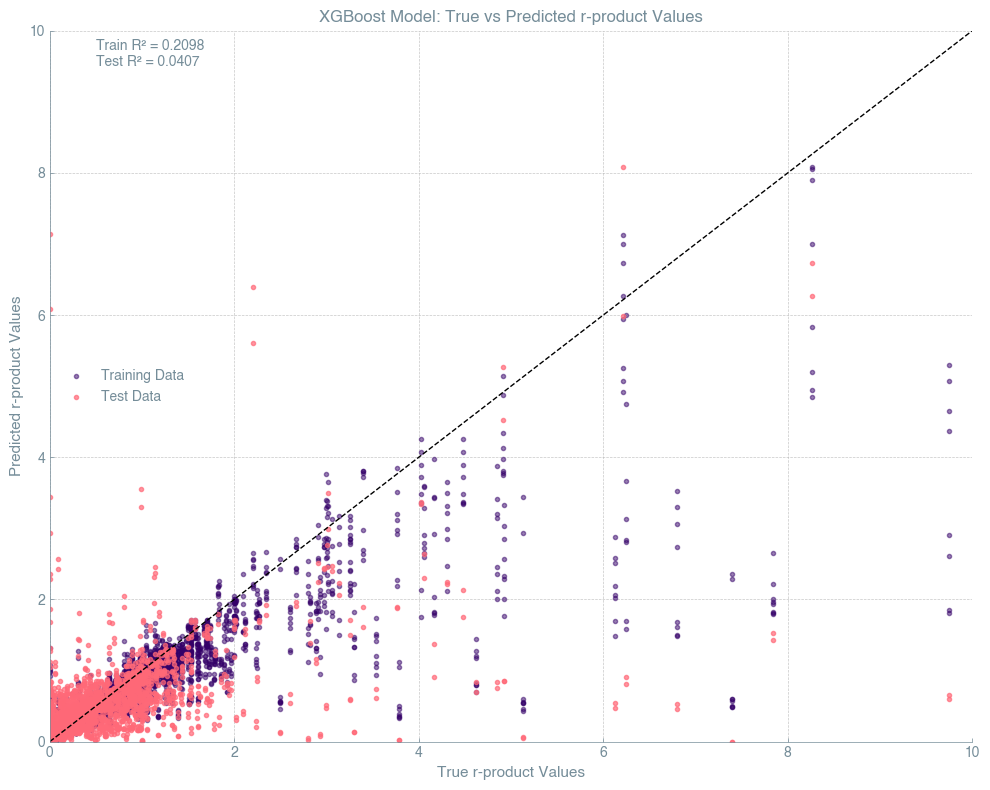

In [6]:
# Plot 1: True vs Predicted values with train/test differentiation - Cross-validation style
plt.figure(figsize=(10, 8), facecolor='white')

# Set white background for the plot area
plt.rcParams['axes.facecolor'] = 'white'

# Load the data
df = pd.read_csv("../output/xgboost_predictions_for_error_analysis.csv")

# Split into train and test sets
train_df = df[df['data_type'] == 'train'].copy()
test_df = df[df['data_type'] == 'test'].copy()

# Remove NaN values
train_df = train_df.dropna(subset=['true_r1r2', 'pred_r1r2'])
test_df = test_df.dropna(subset=['true_r1r2', 'pred_r1r2'])

print(f"Training samples after removing NaNs: {len(train_df)}")
print(f"Test samples after removing NaNs: {len(test_df)}")

# Extract the values
all_y_train_true = train_df['true_r1r2'].values
all_y_train_pred = train_df['pred_r1r2'].values
all_y_true = test_df['true_r1r2'].values
all_y_pred = test_df['pred_r1r2'].values

# Calculate R² values
train_r2 = r2_score(all_y_train_true, all_y_train_pred)
test_r2 = r2_score(all_y_true, all_y_pred)

# Plot train data with your first color
plt.scatter(all_y_train_true, all_y_train_pred, 
           alpha=0.5, color=colors[0], label='Training Data')

# Plot test data with your second color
plt.scatter(all_y_true, all_y_pred, 
           alpha=0.7, color=colors[1], label='Test Data')

# Perfect prediction line with your third color
plt.plot([0, 10], [0, 10], linestyle='--', color='black')

# Add grid and labels
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('True r-product Values')
plt.ylabel('Predicted r-product Values')
plt.title('XGBoost Model: True vs Predicted r-product Values')
plt.legend()

# Set the axes limits to 0-10
plt.xlim(0, 10)
plt.ylim(0, 10)

# Add R² values as text
plt.text(0.05, 0.95, f'Train R² = {train_r2:.4f}\nTest R² = {test_r2:.4f}', 
         transform=plt.gca().transAxes)

plt.tight_layout()
plt.savefig('xgboost_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

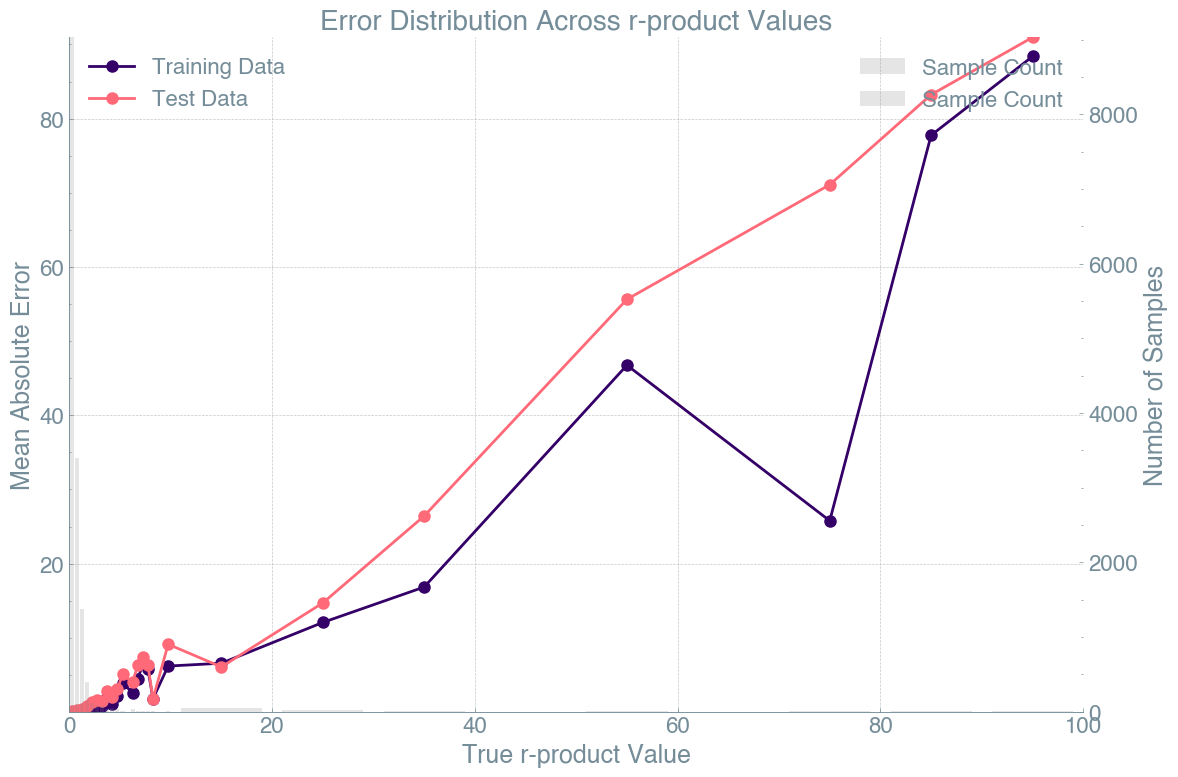

Bin ranges and error statistics:
Range 0.0-0.5: Train samples=7224, Test samples=1806, Train MAE=0.0469, Test MAE=0.1546
Range 0.5-1.0: Train samples=2720, Test samples=680, Train MAE=0.0915, Test MAE=0.2401
Range 1.0-1.5: Train samples=1104, Test samples=276, Train MAE=0.1798, Test MAE=0.4093
Range 1.5-2.0: Train samples=320, Test samples=80, Train MAE=0.3847, Test MAE=0.7472
Range 2.0-2.5: Train samples=88, Test samples=22, Train MAE=0.4901, Test MAE=1.4048
Range 2.5-3.0: Train samples=72, Test samples=18, Train MAE=0.8124, Test MAE=1.6591
Range 3.0-3.5: Train samples=64, Test samples=16, Train MAE=0.7689, Test MAE=1.4216
Range 3.5-4.0: Train samples=24, Test samples=6, Train MAE=2.0756, Test MAE=2.8339
Range 4.0-4.5: Train samples=40, Test samples=10, Train MAE=1.0795, Test MAE=1.9765
Range 4.5-5.0: Train samples=32, Test samples=8, Train MAE=2.1898, Test MAE=3.0870
Range 5.0-5.5: Train samples=8, Test samples=2, Train MAE=3.9425, Test MAE=5.0721
Range 5.5-6.0: Train samples=0, Test

In [7]:
# Plot: Error analysis by r-product value with variable bin sizes and larger fonts
plt.figure(figsize=(12, 8), facecolor='white')

# Ensure white background
plt.rcParams['axes.facecolor'] = 'white'

# Set larger font sizes for all elements
plt.rcParams.update({
    'font.size': 14,             # Base font size
    'axes.titlesize': 20,        # Title font size
    'axes.labelsize': 18,        # Axis label font size
    'xtick.labelsize': 16,       # X-tick label font size
    'ytick.labelsize': 16,       # Y-tick label font size
    'legend.fontsize': 16        # Legend font size
})

# Create custom bins with smaller intervals from 0-10 and then larger intervals
bins_small = np.linspace(0, 10, 21)  # 20 bins from 0 to 10 (intervals of 0.5)
bins_large = np.arange(10, 110, 10)  # Bins of size 10 from 10 to 100
bins = np.concatenate([bins_small, bins_large])
bin_centers = []

# Calculate bin centers manually for each bin
for i in range(len(bins) - 1):
    bin_centers.append((bins[i] + bins[i+1]) / 2)

# Initialize arrays to store errors
train_errors = []
test_errors = []
train_counts = []
test_counts = []

# Calculate mean absolute error for each bin
for i in range(len(bins) - 1):
    # Define bin range
    bin_min, bin_max = bins[i], bins[i+1]
    
    # Filter data for this bin
    train_bin = train_df[(train_df['true_r1r2'] >= bin_min) & (train_df['true_r1r2'] < bin_max)]
    test_bin = test_df[(test_df['true_r1r2'] >= bin_min) & (test_df['true_r1r2'] < bin_max)]
    
    # Store counts
    train_counts.append(len(train_bin))
    test_counts.append(len(test_bin))
    
    # Calculate MAE if there are samples in the bin
    train_mae = np.abs(train_bin['true_r1r2'] - train_bin['pred_r1r2']).mean() if len(train_bin) > 0 else np.nan
    test_mae = np.abs(test_bin['true_r1r2'] - test_bin['pred_r1r2']).mean() if len(test_bin) > 0 else np.nan
    
    train_errors.append(train_mae)
    test_errors.append(test_mae)

# Convert to numpy arrays for easier handling of NaN values
train_errors = np.array(train_errors)
test_errors = np.array(test_errors)
bin_centers = np.array(bin_centers)

# Get non-NaN indices for plotting
train_valid = ~np.isnan(train_errors)
test_valid = ~np.isnan(test_errors)

# Plot the errors with larger markers
plt.plot(bin_centers[train_valid], train_errors[train_valid], '-o', color=colors[0], label='Training Data', markersize=8, linewidth=2)
plt.plot(bin_centers[test_valid], test_errors[test_valid], '-o', color=colors[1], label='Test Data', markersize=8, linewidth=2)

# Add grid and labels
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('True r-product Value', fontsize=18)
plt.ylabel('Mean Absolute Error', fontsize=18)
plt.title('Error Distribution Across r-product Values', fontsize=20)
plt.legend(fontsize=16)

# Set appropriate x-axis limits
plt.xlim(0, 100)

# Create a secondary axis for showing sample counts
ax2 = plt.twinx()
bar_width = [bins[i+1] - bins[i] for i in range(len(bins) - 1)]
ax2.bar(bin_centers, np.array(train_counts) + np.array(test_counts), 
        width=[w * 0.8 for w in bar_width], alpha=0.2, color='gray', label='Sample Count')
ax2.set_ylabel('Number of Samples', fontsize=18)
ax2.set_ylim(bottom=0)
ax2.tick_params(axis='y', labelsize=16)

# Add a second legend for the sample count
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right', fontsize=16)


plt.tight_layout()
plt.savefig('error_by_rproduct_variable_bins.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics for each bin
print("Bin ranges and error statistics:")
for i in range(len(bins) - 1):
    bin_min, bin_max = bins[i], bins[i+1]
    train_count = train_counts[i]
    test_count = test_counts[i]
    train_mae = train_errors[i]
    test_mae = test_errors[i]
    
    print(f"Range {bin_min:.1f}-{bin_max:.1f}: Train samples={train_count}, Test samples={test_count}, "
          f"Train MAE={train_mae:.4f}, Test MAE={test_mae:.4f}")

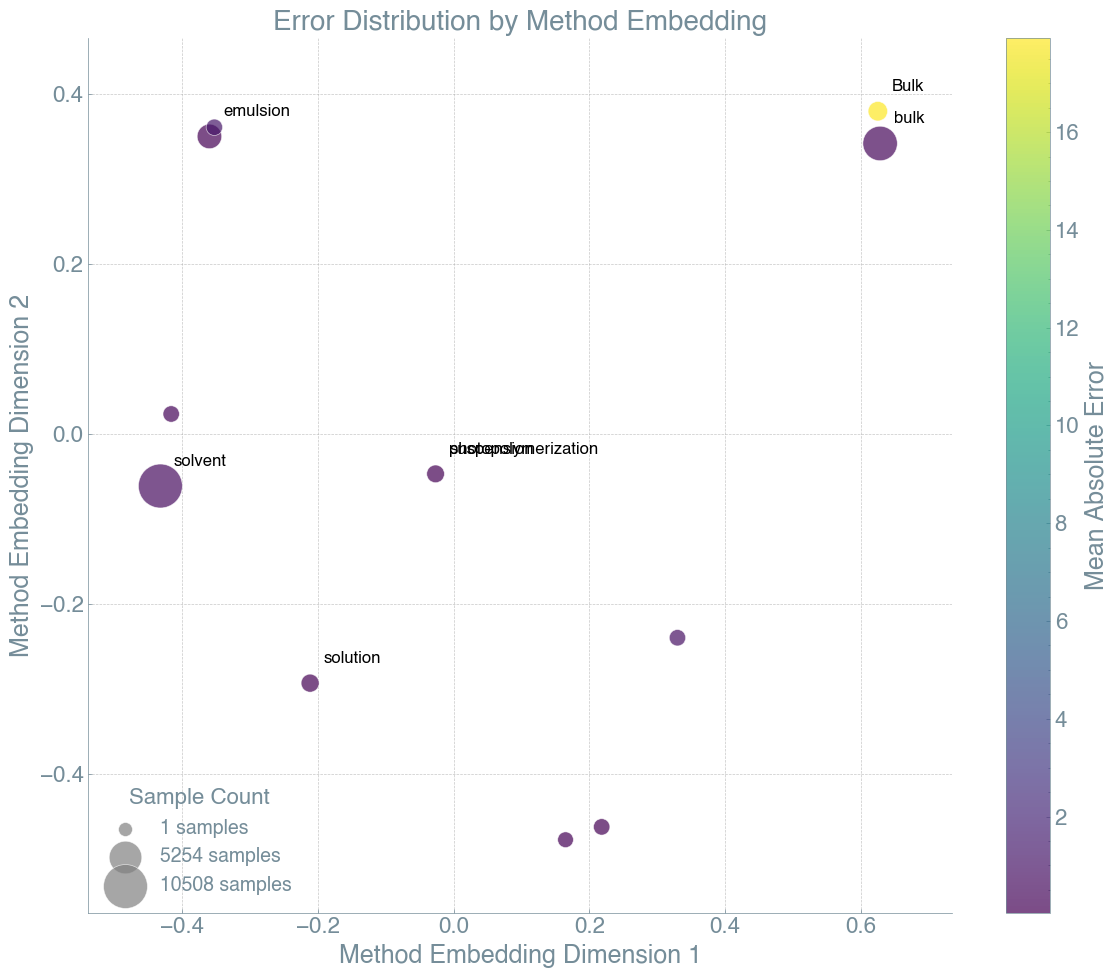

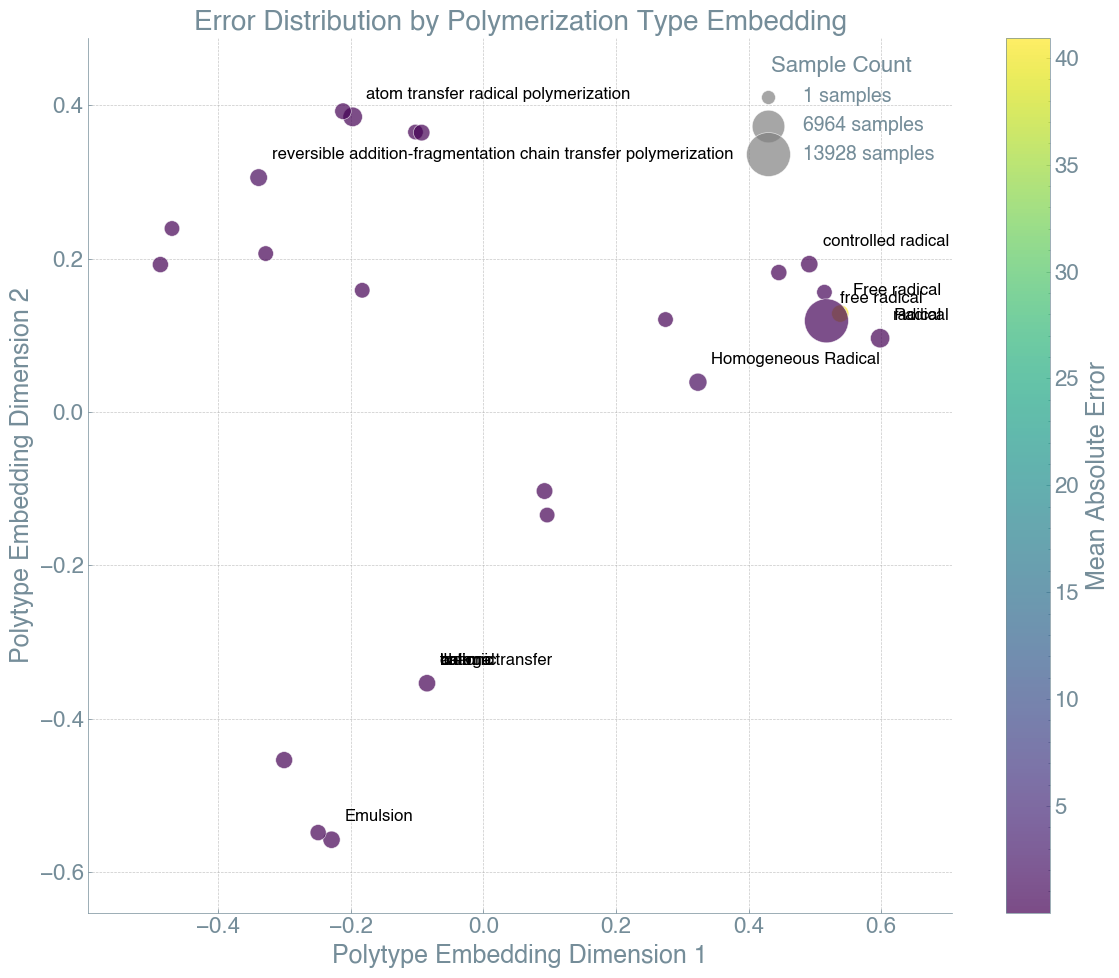


Top 5 methods by average error:
                       mean  count
method                            
Bulk              17.917778    121
inverse emulsion   1.212976     20
KBr tablet         0.842199     20
solvent            0.631608  10508
bulk               0.330638   3430

Polymerization types by average error:
                                                         mean  count
polymerization_type                                                 
Free radical                                        40.906165     51
Homogeneous Radical                                  1.036116     80
reversible addition-fragmentation chain transfe...   0.881614     60
free radical                                         0.556246  13928
Free Radical                                         0.512223     10
atom transfer radical polymerization                 0.144002    160
radical                                              0.136507    150
controlled radical                                   0.130130

In [9]:
# Error analysis by method and polymerization type embeddings

with open('../output/method_emb_pca_values.json', 'r') as f:
    method_labels_dict = json.load(f)

with open('../output/polytype_emb_pca_values.json', 'r') as f:
    polytype_labels_dict = json.load(f)

method_labels_df = pd.DataFrame.from_dict(method_labels_dict, orient='index').reset_index()
method_labels_df.columns = ['label', 'x', 'y']

polytype_labels_df = pd.DataFrame.from_dict(polytype_labels_dict, orient='index').reset_index()
polytype_labels_df.columns = ['label', 'x', 'y']

# First, check if the embedding columns exist in the dataframe
method_emb_cols = [col for col in df.columns if 'method_emb' in col]
polytype_emb_cols = [col for col in df.columns if 'polytype_emb' in col]

# Create the plots if the embedding columns exist
if method_emb_cols and polytype_emb_cols:
    # Combine train and test data for these plots
    combined_df = pd.concat([train_df, test_df], ignore_index=True)
    
    # Calculate absolute error for coloring
    combined_df['abs_error'] = np.abs(combined_df['true_r1r2'] - combined_df['pred_r1r2'])
    
    # 1. Plot for Method Embeddings
    plt.figure(figsize=(12, 10), facecolor='white')
    plt.rcParams['axes.facecolor'] = 'white'
    
    # Get the first two method embedding dimensions
    x_col = method_emb_cols[0]
    y_col = method_emb_cols[1] if len(method_emb_cols) > 1 else method_emb_cols[0]
    
    # Group by unique method embeddings and calculate average error and count
    if 'method' in combined_df.columns:
        method_groups = combined_df.groupby(['method', x_col, y_col])['abs_error'].agg(['mean', 'count']).reset_index()
    else:
        # If 'method' column doesn't exist, group by embedding coordinates
        method_groups = combined_df.groupby([x_col, y_col])['abs_error'].agg(['mean', 'count']).reset_index()
    
    # Scale sizes based on count (sqrt for better visual scaling)
    max_count = method_groups['count'].max()
    min_size = 100
    max_size = 1000
    method_groups['point_size'] = min_size + (max_size - min_size) * np.sqrt(method_groups['count'] / max_count)
    
    # Create a scatter plot with error-based coloring and size based on count
    scatter = plt.scatter(method_groups[x_col], method_groups[y_col], 
                         c=method_groups['mean'], cmap='viridis', 
                         s=method_groups['point_size'], alpha=0.7, 
                         edgecolors='w', linewidth=0.5)
    
    # Add color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Mean Absolute Error', fontsize=18)
    cbar.ax.tick_params(labelsize=16)
    
    # Add titles and labels
    plt.title('Error Distribution by Method Embedding', fontsize=20)
    plt.xlabel(f'Method Embedding Dimension 1', fontsize=18)
    plt.ylabel(f'Method Embedding Dimension 2', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=16)
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add padding to avoid cut-off points
    x_min, x_max = method_groups[x_col].min(), method_groups[x_col].max()
    y_min, y_max = method_groups[y_col].min(), method_groups[y_col].max()
    x_padding = (x_max - x_min) * 0.1
    y_padding = (y_max - y_min) * 0.1
    plt.xlim(x_min - x_padding, x_max + x_padding)
    plt.ylim(y_min - y_padding, y_max + y_padding)
    from scipy.spatial import KDTree

    # Koordinaten und Labels aus JSON
    label_coords = method_labels_df[['x', 'y']].values
    labels = method_labels_df['label'].values

    # KDTree für method_groups aufbauen
    embedding_coords = method_groups[[x_col, y_col]].values
    tree = KDTree(embedding_coords)

    # Threshold
    min_count = 50
    offset_x = 0.02
    offset_y = 0.02

    for i, (label, coord) in enumerate(zip(labels, label_coords)):
        dist, idx = tree.query(coord)
        row = method_groups.iloc[idx]
    
        if row['count'] >= min_count:
            plt.text(row[x_col] + offset_x, row[y_col] + offset_y, label,
                 fontsize=12, ha='left', va='bottom', color='black')

    # Add a legend for point sizes
    sizes = [min_size, (min_size + max_size) / 2, max_size]
    counts = [1, int(max_count / 2), max_count]
    for size, count in zip(sizes, counts):
        plt.scatter([], [], c='gray', alpha=0.7, s=size, edgecolors='w', linewidth=0.5,
                   label=f'{count} samples')
    plt.legend(title='Sample Count', fontsize=14, title_fontsize=16)
    
    plt.tight_layout()
    plt.savefig('error_by_method_embedding.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Plot for Polymerization Type Embeddings
    plt.figure(figsize=(12, 10), facecolor='white')
    plt.rcParams['axes.facecolor'] = 'white'
    
    # Get the first two polytype embedding dimensions
    x_col = polytype_emb_cols[0]
    y_col = polytype_emb_cols[1] if len(polytype_emb_cols) > 1 else polytype_emb_cols[0]
    
    # Group by unique polytype embeddings and calculate average error and count
    if 'polymerization_type' in combined_df.columns:
        polytype_groups = combined_df.groupby(['polymerization_type', x_col, y_col])['abs_error'].agg(['mean', 'count']).reset_index()
    else:
        # If 'polymerization_type' column doesn't exist, group by embedding coordinates
        polytype_groups = combined_df.groupby([x_col, y_col])['abs_error'].agg(['mean', 'count']).reset_index()
    
    # Scale sizes based on count (sqrt for better visual scaling)
    max_count = polytype_groups['count'].max()
    polytype_groups['point_size'] = min_size + (max_size - min_size) * np.sqrt(polytype_groups['count'] / max_count)
    
    # Create a scatter plot with error-based coloring and size based on count
    scatter = plt.scatter(polytype_groups[x_col], polytype_groups[y_col], 
                         c=polytype_groups['mean'], cmap='viridis', 
                         s=polytype_groups['point_size'], alpha=0.7, 
                         edgecolors='w', linewidth=0.5)
    
    # Add color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Mean Absolute Error', fontsize=18)
    cbar.ax.tick_params(labelsize=16)
    
    # Add titles and labels
    plt.title('Error Distribution by Polymerization Type Embedding', fontsize=20)
    plt.xlabel(f'Polytype Embedding Dimension 1', fontsize=18)
    plt.ylabel(f'Polytype Embedding Dimension 2', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=16)
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add padding to avoid cut-off points
    x_min, x_max = polytype_groups[x_col].min(), polytype_groups[x_col].max()
    y_min, y_max = polytype_groups[y_col].min(), polytype_groups[y_col].max()
    x_padding = (x_max - x_min) * 0.1
    y_padding = (y_max - y_min) * 0.1
    plt.xlim(x_min - x_padding, x_max + x_padding)
    plt.ylim(y_min - y_padding, y_max + y_padding)
    
    label_coords = polytype_labels_df[['x', 'y']].values
    labels = polytype_labels_df['label'].values
    embedding_coords = polytype_groups[[x_col, y_col]].values
    tree = KDTree(embedding_coords)

    for i, (label, coord) in enumerate(zip(labels, label_coords)):
        dist, idx = tree.query(coord)
        row = polytype_groups.iloc[idx]
    
        if row['count'] >= min_count:
            plt.text(row[x_col] + offset_x, row[y_col] + offset_y, label,
                 fontsize=12, ha='left', va='bottom', color='black')

    
    # Add a legend for point sizes
    sizes = [min_size, (min_size + max_size) / 2, max_size]
    counts = [1, int(max_count / 2), max_count]
    for size, count in zip(sizes, counts):
        plt.scatter([], [], c='gray', alpha=0.7, s=size, edgecolors='w', linewidth=0.5,
                   label=f'{count} samples')
    plt.legend(title='Sample Count', fontsize=14, title_fontsize=16)
    
    plt.tight_layout()
    plt.savefig('error_by_polytype_embedding.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    if 'method' in combined_df.columns:
        print("\nTop 5 methods by average error:")
        method_errors = combined_df.groupby('method')['abs_error'].agg(['mean', 'count']).sort_values('mean', ascending=False)
        print(method_errors.head(5))
    
    if 'polymerization_type' in combined_df.columns:
        print("\nPolymerization types by average error:")
        polytype_errors = combined_df.groupby('polymerization_type')['abs_error'].agg(['mean', 'count']).sort_values('mean', ascending=False)
        print(polytype_errors)
    
    # Important change: Average errors over the same reaction IDs
    # First, check if 'reaction_id' is in the columns
    if 'reaction_id' in combined_df.columns:
        print("\nTop 5 reaction_ids with the largest average errors:")
        
        # Calculate the average error per reaction ID
        rxn_errors = combined_df.groupby('reaction_id').agg({
            'abs_error': 'mean',
            'true_r1r2': 'mean',
            'pred_r1r2': 'mean',
            'monomer1_name': 'first',
            'monomer2_name': 'first',
            'method': 'first',
            'polymerization_type': 'first',
            'source_filename': 'first'
        }).reset_index()
        
        # Sort by average error
        rxn_errors = rxn_errors.sort_values('abs_error', ascending=False)
        
        # Define columns to display
        display_columns = ['reaction_id', 'abs_error', 'true_r1r2', 'pred_r1r2', 'monomer1_name', 'monomer2_name', 
                          'method', 'polymerization_type', 'source_filename']
        
        # Check if JSON columns exist
        json_columns = [col for col in ['json_filename_1', 'json_filename_2', 'monomer1_json', 'monomer2_json'] 
                       if col in combined_df.columns]
        
        if json_columns:
            for col in json_columns:
                rxn_errors[col] = combined_df.groupby('reaction_id')[col].first().values
            display_columns.extend(json_columns)
        
        # Display top 5 errors
        top_rxn_errors = rxn_errors.head(5)
        
        # Check which columns actually exist
        existing_columns = [col for col in display_columns if col in top_rxn_errors.columns]
        
        # Display error details
        error_table = top_rxn_errors[existing_columns].reset_index(drop=True)
        pd.set_option('display.max_columns', None)  # Show all columns
        pd.set_option('display.width', 1000)        # Wider display
        print(error_table)
        
        # Export error table to CSV for easier reference
        error_table.to_csv('top_errors_by_rxn_id.csv', index=False)
        print("Top errors by reaction ID exported to 'top_errors_by_rxn_id.csv'")
    else:
        # If no 'reaction_id' is present, use the original code
        print("\nTop 5 individual data points with the largest errors:")
        
        # Define columns to display
        display_columns = ['abs_error', 'true_r1r2', 'pred_r1r2', 'monomer1_name', 'monomer2_name', 
                          'method', 'polymerization_type', 'source_filename']
        
        # Add JSON filename columns if they exist
        if 'json_filename_1' in combined_df.columns:
            display_columns.append('json_filename_1')
        if 'json_filename_2' in combined_df.columns:
            display_columns.append('json_filename_2')
        if 'monomer1_json' in combined_df.columns:
            display_columns.append('monomer1_json')
        if 'monomer2_json' in combined_df.columns:
            display_columns.append('monomer2_json')
        
        # Get the top 5 errors and their details
        top_errors = combined_df.sort_values('abs_error', ascending=False).head(5)
        
        # Check which columns actually exist
        existing_columns = [col for col in display_columns if col in top_errors.columns]
        
        # Display error details
        error_table = top_errors[existing_columns].reset_index(drop=True)
        pd.set_option('display.max_columns', None)  # Show all columns
        pd.set_option('display.width', 1000)        # Wider display
        print(error_table)
        
        # Export error table to CSV for easier reference
        error_table.to_csv('top_errors.csv', index=False)
        print("Top errors exported to 'top_errors.csv'")
        
    # Analyze errors relative to original sources
    if 'source_filename' in combined_df.columns:
        print("\nTop 5 source files by average error:")
        source_errors = combined_df.groupby('source_filename')['abs_error'].agg(['mean', 'count']).sort_values('mean', ascending=False)
        source_errors = source_errors[source_errors['count'] >= 5]  
        print(source_errors.head(5))
        
        # Analyze errors relative to original files
        if 'json_filename_1' in combined_df.columns and 'json_filename_2' in combined_df.columns:
            print("\nTop 5 JSON file pairs by average error:")
            json_errors = combined_df.groupby(['json_filename_1', 'json_filename_2'])['abs_error'].agg(['mean', 'count']).sort_values('mean', ascending=False)
            json_errors = json_errors[json_errors['count'] >= 3]  
            print(json_errors.head(5))

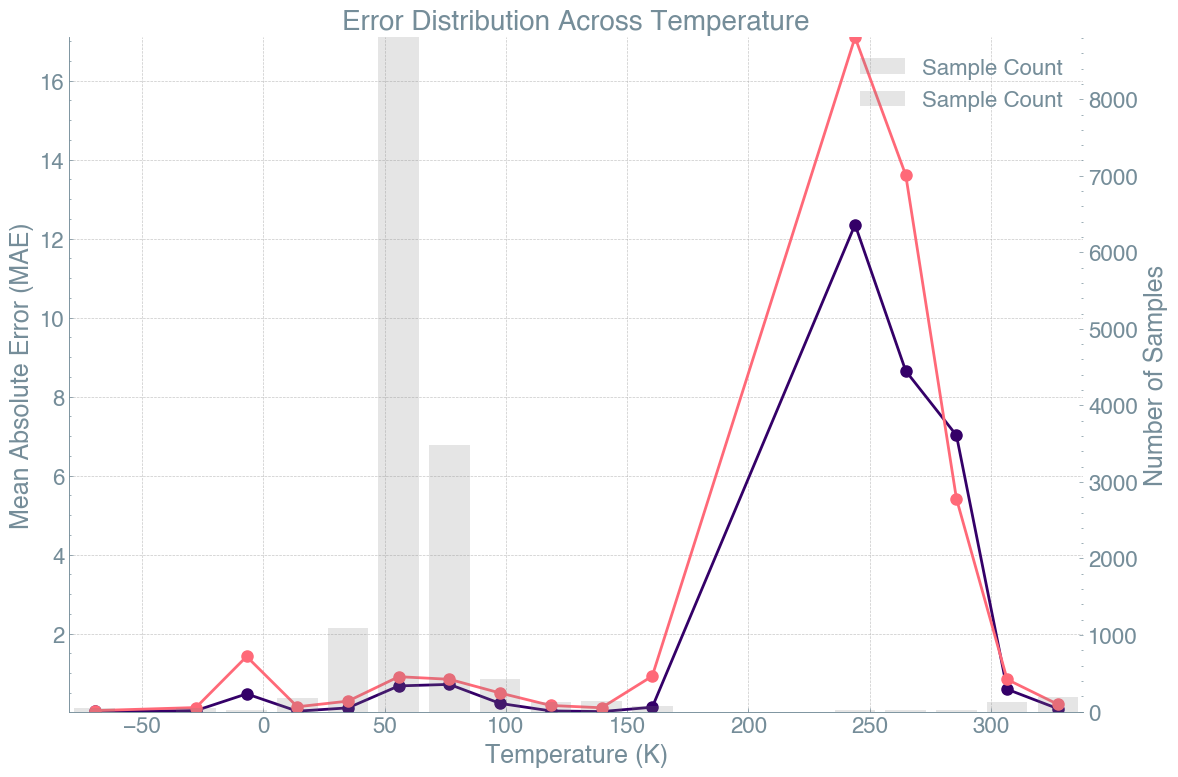

Bin ranges and error statistics:
Range -80.0--59.1: Train samples=40, Test samples=10, Train MAE=0.0317, Test MAE=0.0537
Range -59.1--38.2: Train samples=0, Test samples=0, Train MAE=nan, Test MAE=nan
Range -38.2--17.3: Train samples=40, Test samples=10, Train MAE=0.0545, Test MAE=0.1317
Range -17.3-3.6: Train samples=16, Test samples=4, Train MAE=0.4782, Test MAE=1.4240
Range 3.6-24.5: Train samples=144, Test samples=36, Train MAE=0.0398, Test MAE=0.1513
Range 24.5-45.4: Train samples=872, Test samples=218, Train MAE=0.1236, Test MAE=0.2943
Range 45.4-66.3: Train samples=7046, Test samples=1762, Train MAE=0.6797, Test MAE=0.9128
Range 66.3-87.2: Train samples=2785, Test samples=696, Train MAE=0.7178, Test MAE=0.8468
Range 87.2-108.1: Train samples=336, Test samples=84, Train MAE=0.2363, Test MAE=0.4997
Range 108.1-129.0: Train samples=104, Test samples=26, Train MAE=0.0463, Test MAE=0.1839
Range 129.0-149.9: Train samples=112, Test samples=28, Train MAE=0.0295, Test MAE=0.1263
Range 1

In [10]:
colors = [
    '#340068',
    '#FF6978',
    '#FFFCF9',
    '#B1EDE8',
    '#6D435A'
]

plt.figure(figsize=(12, 8), facecolor='white')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16
})

# Define temperature bin range
temp_min = min(train_df['temperature'].min(), test_df['temperature'].min())
temp_max = max(train_df['temperature'].max(), test_df['temperature'].max())

# Create bins and centers
bins = np.linspace(temp_min, temp_max, 21)  # 20 equal-width bins
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Initialize storage for MAE and sample counts
train_errors, test_errors = [], []
train_counts, test_counts = [], []

# Compute MAE and counts per temperature bin
for i in range(len(bins) - 1):
    bin_min, bin_max = bins[i], bins[i + 1]
    
    train_bin = train_df[(train_df['temperature'] >= bin_min) & (train_df['temperature'] < bin_max)]
    test_bin = test_df[(test_df['temperature'] >= bin_min) & (test_df['temperature'] < bin_max)]
    
    train_counts.append(len(train_bin))
    test_counts.append(len(test_bin))
    
    train_mae = train_bin['abs_error_r1r2'].mean() if len(train_bin) > 0 else np.nan
    test_mae = test_bin['abs_error_r1r2'].mean() if len(test_bin) > 0 else np.nan
    
    train_errors.append(train_mae)
    test_errors.append(test_mae)

# Convert to numpy arrays for easy filtering
train_errors = np.array(train_errors)
test_errors = np.array(test_errors)
train_counts = np.array(train_counts)
test_counts = np.array(test_counts)
sample_counts = train_counts + test_counts

# Get valid indices for plotting
train_valid = ~np.isnan(train_errors)
test_valid = ~np.isnan(test_errors)

# Plot MAE lines
plt.plot(bin_centers[train_valid], train_errors[train_valid], '-o',
         color=colors[0], label='Training Data', markersize=8, linewidth=2)

plt.plot(bin_centers[test_valid], test_errors[test_valid], '-o',
         color=colors[1], label='Test Data', markersize=8, linewidth=2)


# Axes and title
plt.xlabel('Temperature (K)', fontsize=18)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=18)
plt.title('Error Distribution Across Temperature', fontsize=20)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(temp_min, temp_max)

# Add sample count as secondary axis (bar plot)
ax2 = plt.twinx()
bar_width = bins[1] - bins[0]

ax2.bar(bin_centers, sample_counts, 
        width=bar_width * 0.8, alpha=0.2, color='gray', label='Sample Count')
ax2.set_ylabel('Number of Samples', fontsize=18)
ax2.set_ylim(bottom=0)
ax2.tick_params(axis='y', labelsize=16)

# Combine legends from both axes
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right', fontsize=16)

plt.tight_layout()
plt.savefig('error_by_temperature.png', dpi=300, bbox_inches='tight')
plt.show()

# Optional: print statistics per bin
print("Bin ranges and error statistics:")
for i in range(len(bins) - 1):
    print(f"Range {bins[i]:.1f}-{bins[i+1]:.1f}: "
          f"Train samples={train_counts[i]}, Test samples={test_counts[i]}, "
          f"Train MAE={train_errors[i]:.4f}, Test MAE={test_errors[i]:.4f}")


[15:46:22] DEPRECATION WARNING: please use MorganGenerator
[15:46:22] DEPRECATION WARNING: please use MorganGenerator
[15:46:22] DEPRECATION WARNING: please use MorganGenerator
[15:46:22] DEPRECATION WARNING: please use MorganGenerator
[15:46:22] DEPRECATION WARNING: please use MorganGenerator
[15:46:22] DEPRECATION WARNING: please use MorganGenerator
[15:46:22] DEPRECATION WARNING: please use MorganGenerator
[15:46:22] DEPRECATION WARNING: please use MorganGenerator
[15:46:22] DEPRECATION WARNING: please use MorganGenerator
[15:46:22] DEPRECATION WARNING: please use MorganGenerator
[15:46:22] DEPRECATION WARNING: please use MorganGenerator
[15:46:22] DEPRECATION WARNING: please use MorganGenerator
[15:46:22] DEPRECATION WARNING: please use MorganGenerator
[15:46:22] DEPRECATION WARNING: please use MorganGenerator
[15:46:22] DEPRECATION WARNING: please use MorganGenerator
[15:46:22] DEPRECATION WARNING: please use MorganGenerator
[15:46:22] DEPRECATION WARNING: please use MorganGenerat

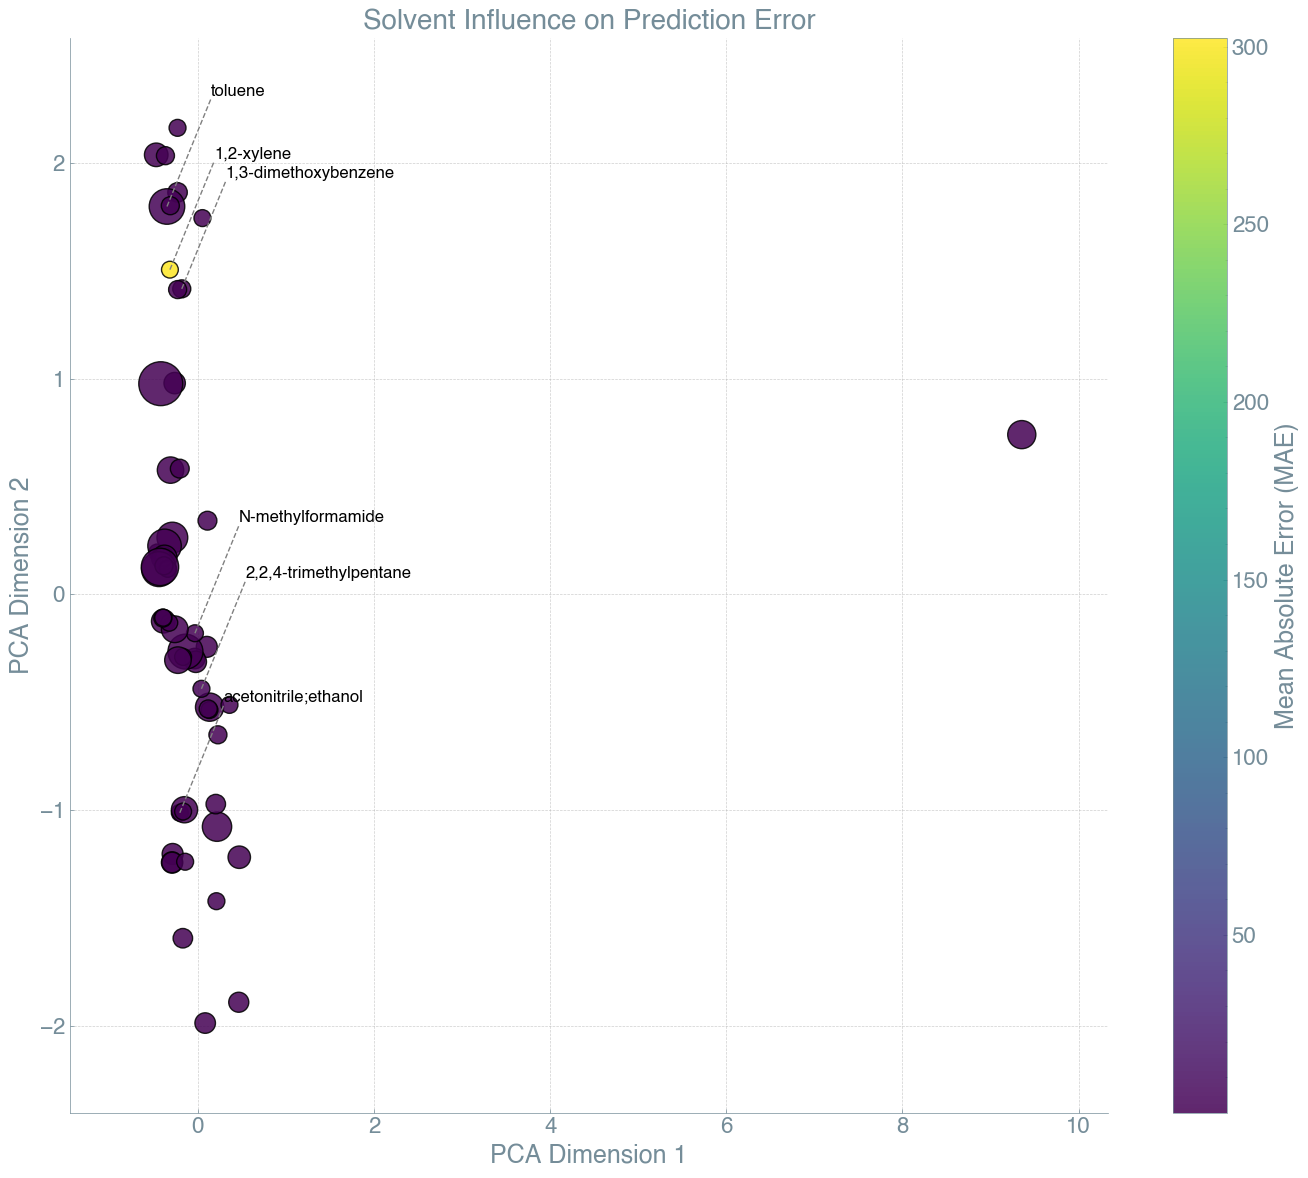

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from rdkit import Chem
from rdkit.Chem import AllChem
import pubchempy as pcp

# Group by solvent SMILES and compute mean absolute error and count
solvent_groups = df.groupby('solvent_smiles')['abs_error_r1r2'].agg(['mean', 'count']).reset_index()
solvent_groups.columns = ['smiles', 'mae', 'count']

# Convert SMILES to Morgan fingerprint
def smiles_to_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)

# Convert SMILES to IUPAC name via PubChem
def smiles_to_iupac(smiles):
    try:
        compound = pcp.get_compounds(smiles, namespace='smiles')
        if compound and compound[0].iupac_name:
            return compound[0].iupac_name
    except:
        pass
    return smiles[:10] + '...'

# Compute fingerprints and IUPAC names
solvent_groups['fp'] = solvent_groups['smiles'].apply(smiles_to_fp)
solvent_groups = solvent_groups[solvent_groups['fp'].notnull()]
solvent_groups['name'] = solvent_groups['smiles'].apply(smiles_to_iupac)

# Apply PCA to reduce fingerprint dimensions
fps = solvent_groups['fp'].tolist()
X = np.array([list(map(int, fp.ToBitString())) for fp in fps])
pca = PCA(n_components=2)
coords = pca.fit_transform(X)
solvent_groups['x'] = coords[:, 0]
solvent_groups['y'] = coords[:, 1]

# Set up plot style
plt.figure(figsize=(14, 12), facecolor='white')
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16
})

# Scale point size by number of data points
min_size = 100
max_size = 1000
max_count = solvent_groups['count'].max()
solvent_groups['point_size'] = min_size + (max_size - min_size) * (solvent_groups['count'] / max_count)**0.5

# Scatter plot: color = MAE, size = count
scatter = plt.scatter(solvent_groups['x'], solvent_groups['y'],
                      c=solvent_groups['mae'],
                      s=solvent_groups['point_size'],
                      cmap='viridis',
                      edgecolors='k',
                      alpha=0.85)

# Colorbar for MAE
cbar = plt.colorbar(scatter)
cbar.set_label('Mean Absolute Error (MAE)', fontsize=18)

plt.title('Solvent Influence on Prediction Error')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.grid(True, linestyle='--', alpha=0.6)

# Add labels and connector lines for solvents with highest and lowest MAE
top_n = 3
highlighted = pd.concat([
    solvent_groups.sort_values('mae', ascending=False).head(top_n),
    solvent_groups.sort_values('mae', ascending=True).head(top_n)
])

offset_x = 0.5
offset_y = 0.5

for _, row in highlighted.iterrows():
    x, y = row['x'], row['y']
    label_x, label_y = x + offset_x, y + offset_y
    plt.plot([x, label_x], [y, label_y], color='gray', linestyle='--', linewidth=1)
    plt.text(label_x, label_y, row['name'], fontsize=12, ha='left', va='bottom', color='black')

# Add padding around plot
x_pad = (solvent_groups['x'].max() - solvent_groups['x'].min()) * 0.1
y_pad = (solvent_groups['y'].max() - solvent_groups['y'].min()) * 0.1
plt.xlim(solvent_groups['x'].min() - x_pad, solvent_groups['x'].max() + x_pad)
plt.ylim(solvent_groups['y'].min() - y_pad, solvent_groups['y'].max() + y_pad)

plt.tight_layout()
plt.savefig("solvent_error_iupac_labeled.png", dpi=300, bbox_inches='tight')
plt.show()


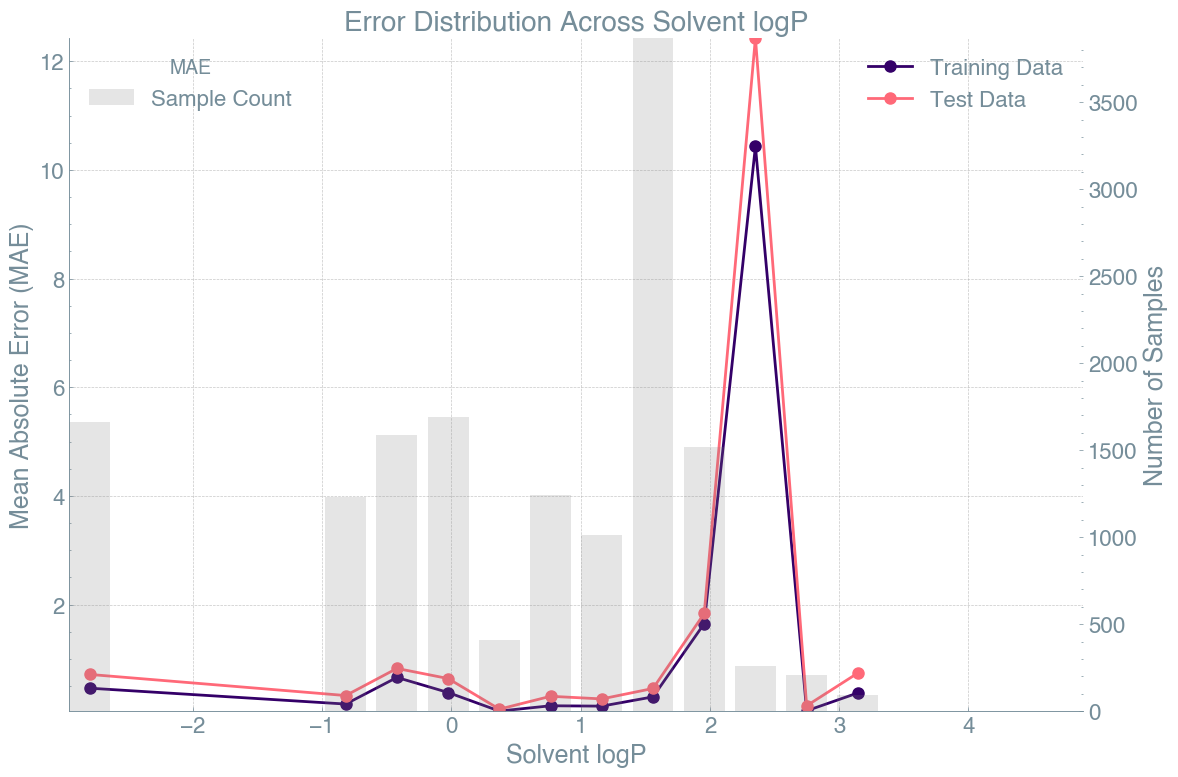

In [12]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8), facecolor='white')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16
})

# Define binning for solvent_logp
logp_min = min(train_df['solvent_logp'].min(), test_df['solvent_logp'].min())
logp_max = max(train_df['solvent_logp'].max(), test_df['solvent_logp'].max())
bins = np.linspace(logp_min, logp_max, 21)  # 20 bins
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Storage
train_errors = []
test_errors = []
train_counts = []
test_counts = []

# Bin by solvent_logp and compute MAE
for i in range(len(bins) - 1):
    bin_min, bin_max = bins[i], bins[i + 1]
    
    train_bin = train_df[(train_df['solvent_logp'] >= bin_min) & (train_df['solvent_logp'] < bin_max)]
    test_bin = test_df[(test_df['solvent_logp'] >= bin_min) & (test_df['solvent_logp'] < bin_max)]
    
    train_counts.append(len(train_bin))
    test_counts.append(len(test_bin))
    
    train_mae = train_bin['abs_error_r1r2'].mean() if len(train_bin) > 0 else np.nan
    test_mae = test_bin['abs_error_r1r2'].mean() if len(test_bin) > 0 else np.nan
    
    train_errors.append(train_mae)
    test_errors.append(test_mae)

train_errors = np.array(train_errors)
test_errors = np.array(test_errors)
train_valid = ~np.isnan(train_errors)
test_valid = ~np.isnan(test_errors)

# Plot MAE curves
colors = ['#340068', '#FF6978']  # Example colors (Training, Test)
plt.plot(bin_centers[train_valid], train_errors[train_valid], '-o',
         color=colors[0], label='Training Data', markersize=8, linewidth=2)
plt.plot(bin_centers[test_valid], test_errors[test_valid], '-o',
         color=colors[1], label='Test Data', markersize=8, linewidth=2)

plt.xlabel('Solvent logP')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Error Distribution Across Solvent logP')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=16)

# Add bar plot for sample counts
ax2 = plt.twinx()
bar_width = bins[1] - bins[0]
sample_counts = np.array(train_counts) + np.array(test_counts)

ax2.bar(bin_centers, sample_counts, 
        width=bar_width * 0.8, alpha=0.2, color='gray', label='Sample Count')
ax2.set_ylabel('Number of Samples', fontsize=18)
ax2.set_ylim(bottom=0)
ax2.tick_params(axis='y', labelsize=16)

ax = plt.gca()

# Legend for lines on left
ax.legend(loc='upper left', fontsize=16, title='MAE')

# Legend for bar plot on right
#ax2.legend(loc='upper right', fontsize=16, title='Count')


plt.tight_layout()
plt.savefig("error_by_solvent_logp.png", dpi=300, bbox_inches='tight')
plt.show()


[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerat

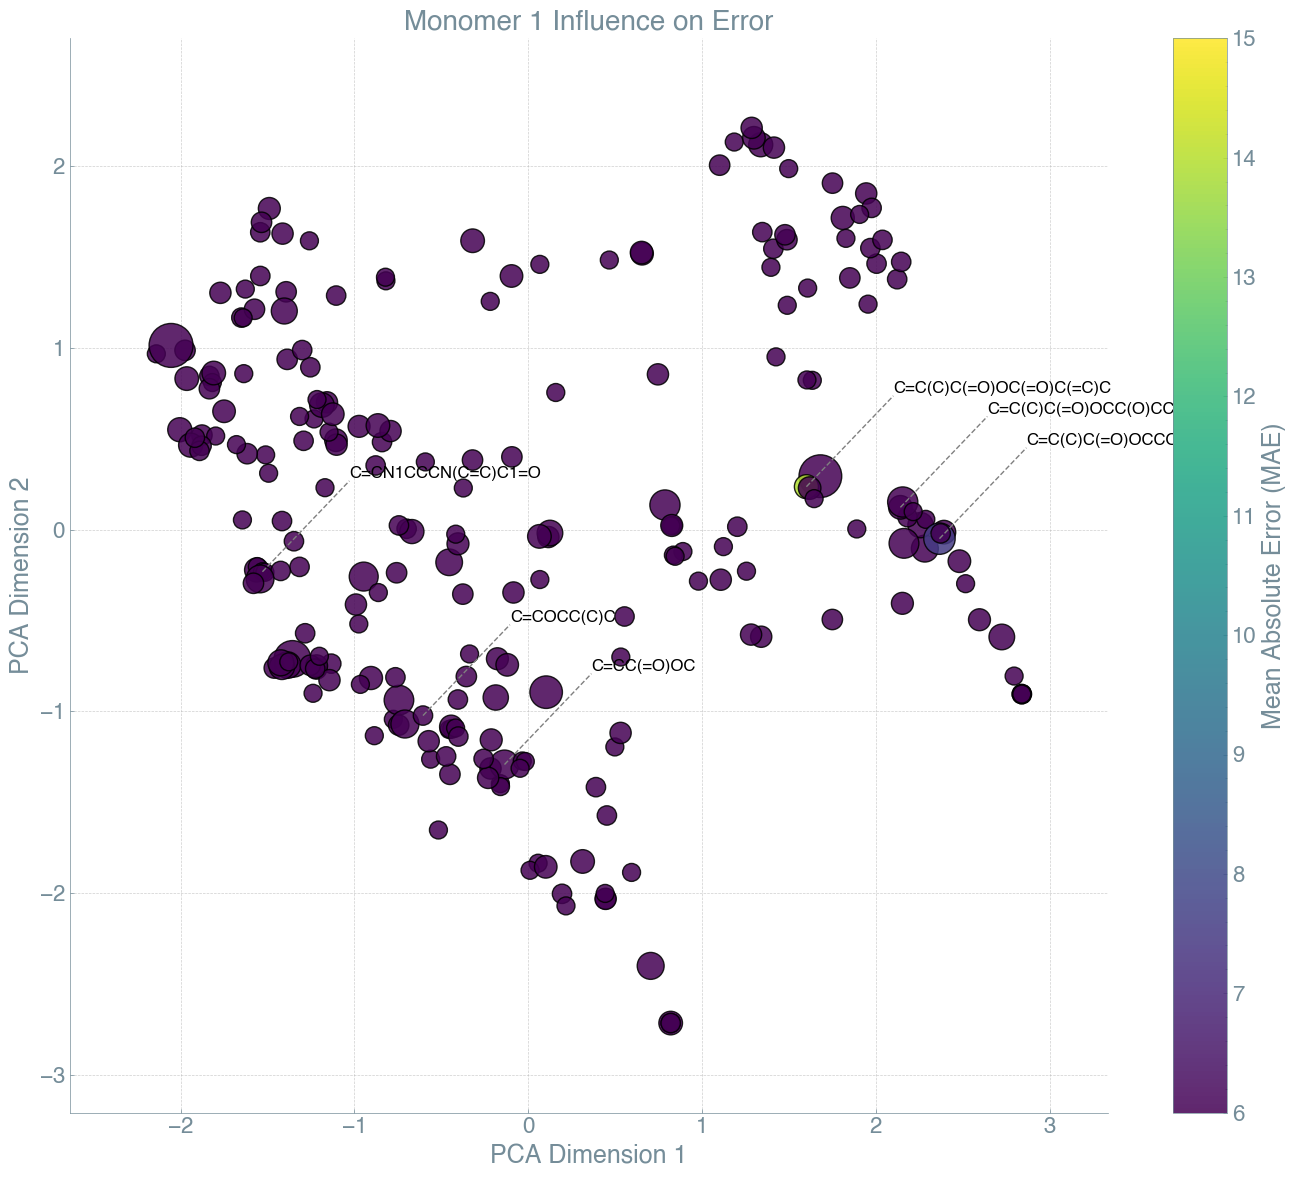

[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerator
[15:47:22] DEPRECATION WARNING: please use MorganGenerat

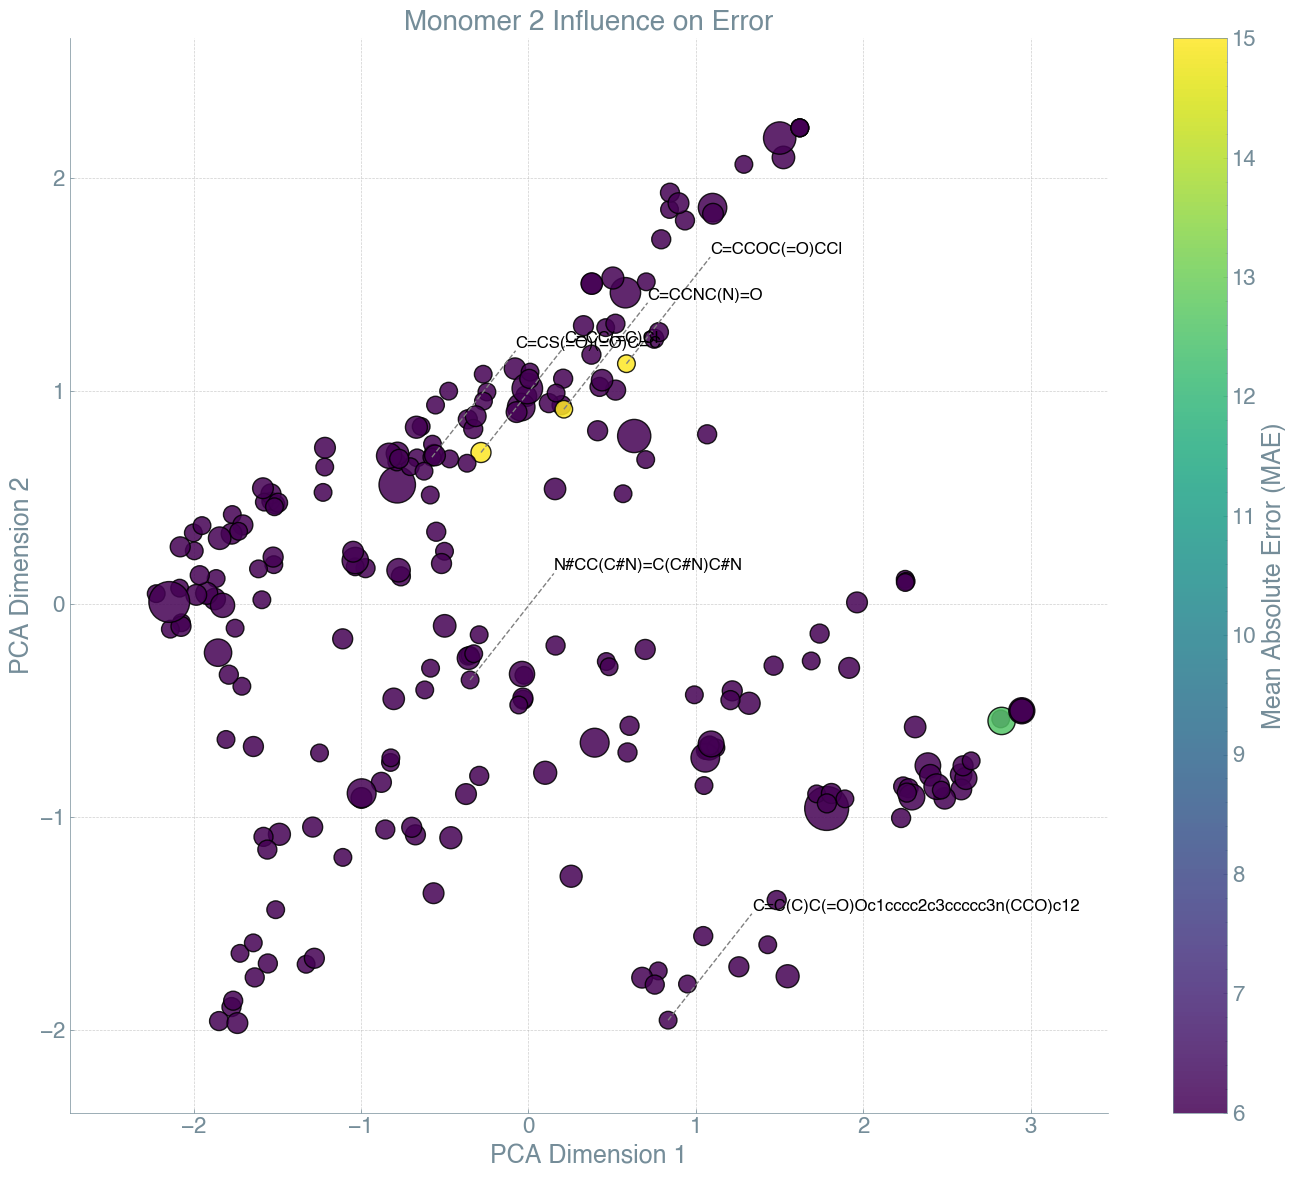

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from rdkit import Chem
from rdkit.Chem import AllChem

def smiles_to_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)

def plot_monomer_smiles_embedding(df, column='monomer1_smiles', title='Monomer 1 Influence on Error', filename='monomer1_mae_plot.png'):
    # Group by monomer smiles
    grouped = df.groupby(column)['abs_error_r1r2'].agg(['mean', 'count']).reset_index()
    grouped.columns = ['smiles', 'mae', 'count']
    
    # Fingerprints
    grouped['fp'] = grouped['smiles'].apply(smiles_to_fp)
    grouped = grouped[grouped['fp'].notnull()]
    
    # Fingerprints to matrix
    fps = grouped['fp'].tolist()
    X = np.array([list(map(int, fp.ToBitString())) for fp in fps])
    
    # PCA
    pca = PCA(n_components=2)
    coords = pca.fit_transform(X)
    grouped['x'] = coords[:, 0]
    grouped['y'] = coords[:, 1]
    
    # Point size
    min_size = 100
    max_size = 1000
    max_count = grouped['count'].max()
    grouped['point_size'] = min_size + (max_size - min_size) * (grouped['count'] / max_count)**0.5
    
    # Plot
    plt.figure(figsize=(14, 12), facecolor='white')
    plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 20,
        'axes.labelsize': 18,
        'xtick.labelsize': 16,
        'ytick.labelsize': 16,
        'legend.fontsize': 16
    })

    scatter = plt.scatter(grouped['x'], grouped['y'],
                          c=grouped['mae'],
                          s=grouped['point_size'],
                          cmap='viridis',
                          edgecolors='k',
                          alpha=0.85
                          )
    
    

    cbar = plt.colorbar(scatter)
    
    plt.clim(6,15)
    cbar.set_label('Mean Absolute Error (MAE)', fontsize=18)
    plt.title(title)
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Highlight Top & Bottom monomers by MAE
    top_n = 3
    highlight = pd.concat([
        grouped.sort_values('mae', ascending=False).head(top_n),
        grouped.sort_values('mae', ascending=True).head(top_n)
    ])

    offset_x = 0.5
    offset_y = 0.5

    for _, row in highlight.iterrows():
        x, y = row['x'], row['y']
        label_x, label_y = x + offset_x, y + offset_y
        plt.plot([x, label_x], [y, label_y], color='gray', linestyle='--', linewidth=1)
        plt.text(label_x, label_y, row['smiles'], fontsize=12, ha='left', va='bottom', color='black')

    # Padding
    x_pad = (grouped['x'].max() - grouped['x'].min()) * 0.1
    y_pad = (grouped['y'].max() - grouped['y'].min()) * 0.1
    plt.xlim(grouped['x'].min() - x_pad, grouped['x'].max() + x_pad)
    plt.ylim(grouped['y'].min() - y_pad, grouped['y'].max() + y_pad)

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# Run for both monomers
plot_monomer_smiles_embedding(df, column='monomer1_smiles', title='Monomer 1 Influence on Error', filename='monomer1_mae_plot.png')
plot_monomer_smiles_embedding(df, column='monomer2_smiles', title='Monomer 2 Influence on Error', filename='monomer2_mae_plot.png')


In [14]:
import pandas as pd
import pubchempy as pcp

# Function to get IUPAC name
def smiles_to_iupac(smiles):
    try:
        compound = pcp.get_compounds(smiles, namespace='smiles')
        if compound and compound[0].iupac_name:
            return compound[0].iupac_name
    except:
        pass
    return smiles[:10] + '...'

# Combine monomer1 and monomer2 into one dataframe
monomer1 = df[['monomer1_smiles', 'abs_error_r1r2']].copy()
monomer1.columns = ['smiles', 'abs_error']

monomer2 = df[['monomer2_smiles', 'abs_error_r1r2']].copy()
monomer2.columns = ['smiles', 'abs_error']

combined = pd.concat([monomer1, monomer2], ignore_index=True)

# Group by smiles and compute stats
grouped = combined.groupby('smiles')['abs_error'].agg(['mean', 'std', 'count']).reset_index()
grouped.columns = ['smiles', 'mean_mae', 'std_mae', 'count']
grouped = grouped.sort_values('mean_mae', ascending=False)

# Get IUPAC names
grouped['iupac_name'] = grouped['smiles'].apply(smiles_to_iupac)

# Show top 10
top10 = grouped.head(10)
print("\nTop 10 monomers with highest mean error:")
print(top10[['iupac_name', 'mean_mae', 'std_mae', 'count']].to_string(index=False))



Top 10 monomers with highest mean error:
                                iupac_name  mean_mae   std_mae  count
                           prop-2-enylurea 48.728652  5.230528      9
               prop-2-enyl 2-chloroacetate 39.458798 40.536562     20
                    2-chlorobuta-1,3-diene 21.279965 47.404547    101
2-methylprop-2-enoyl 2-methylprop-2-enoate 13.912353 27.537413     89
               butyl 2-methylprop-2-enoate  7.974554 47.971827    349
      2-hydroxyethyl 2-methylprop-2-enoate  5.451592 39.113280    529
                           furan-2,5-dione  2.815545 14.125504    390
                    1-chlorobuta-1,3-diene  2.376449  3.314825     30
                 1-phenylpyrrole-2,5-dione  2.175563  3.704005     90
                                    ethene  1.963613  4.905286    320


In [15]:
import pandas as pd
import numpy as np
import os

# Create output directory
output_dir = 'error_analysis'
os.makedirs(output_dir, exist_ok=True)

# Check if abs_error column exists, calculate if not
if 'abs_error' not in combined_df.columns:
    if 'true_r1r2' in combined_df.columns and 'pred_r1r2' in combined_df.columns:
        combined_df['abs_error'] = np.abs(combined_df['true_r1r2'] - combined_df['pred_r1r2'])
        print("Absolute error has been calculated.")
    else:
        print("ERROR: Cannot calculate absolute error, missing true_r1r2 or pred_r1r2.")

# Analyze by source_filename
if 'source_filename' in combined_df.columns:
    print("Analyzing errors by source_filename...")
    
    # Calculate error metrics per source file
    source_errors = combined_df.groupby('source_filename')['abs_error'].agg([
        ('mean_error', 'mean'), 
        ('median_error', 'median'), 
        ('std_error', 'std'), 
        ('min_error', 'min'), 
        ('max_error', 'max'), 
        ('count', 'count')
    ]).reset_index()
    
    # Sort by mean error (descending)
    source_errors = source_errors.sort_values('mean_error', ascending=False)
    
    # Save as CSV
    source_errors.to_csv(f"{output_dir}/source_file_errors.csv", index=False)
    
    # Print top 10 files with highest mean error
    print(f"\nTop 10 source files with highest mean error:")
    print(source_errors.head(10)[['source_filename', 'mean_error', 'count']])
    
    print(f"\nError analysis saved to {output_dir}/source_file_errors.csv.")
else:
    print("ERROR: No 'source_filename' column found in the data.")

Analyzing errors by source_filename...

Top 10 source files with highest mean error:
                                       source_filename  mean_error  count
442                         10.3390_polym11030487.json   94.458612     29
366                           10.1021_ja01216a006.json   50.857606     41
163                   10.1002_pol.1961.1205516120.json   31.613547     39
429                      10.1295_koron1944.30.223.json   29.921790     30
8    10.1002__sici_1521-3935_19990801_200_8_1935__a...    9.883177     60
247                   10.1002_pola.1990.080280408.json    6.351236     30
202                    10.1002_pol.1973.170111201.json    4.278707     10
420                          10.1246_bcsj.54.3245.json    2.376449     30
265                            10.1002_pola.23152.json    2.294664     20
431                         10.1295_polymj.17.761.json    1.823750     40

Error analysis saved to error_analysis/source_file_errors.csv.
